# ENPH 213 - Week 9 Lab - Part 5

In this lab, we will be working on numerically solving ordinary differential equations and continuing to develop your Python skills.

When you are finished, please rename this notebook to LastName_ENPH213_Lab9-Part5, where LastName is your last name.  Submit that file to onQ.

For marking Parts 1-4 will be marked together (Weighted out of 10) and Part 5 will be marked out of 5.

In [1]:
import numpy as np
import cmath as cm
import math as m
from matplotlib import pyplot as plt
%matplotlib inline

# Part 5

The Schroedinger equation for a particle in a box reduces to a relatively simple differential equation.

$\Large \frac{d^2 \phi}{dx^2} = (V-E) \phi$

Where the right hand side is simply a constant times $\phi$.  Note that for simplicity, I'm going to choose units such that $\hbar^2/2m = 1$.

There are 3 regions of interest, the quantum well that extends from $-L < x < L$ where the potential $V = 0$, and the regions $x \leq L$ and $x \geq L$ where $V = V$.  The difficulty is at the boundary where the values for $\phi(x)$ and $\phi^\prime(x)$ should be continuous.  With these three regions, the process to solve the provlem is to do each region separately and match them together.

We will this problem using the 2nd Order Central Difference solver discussed in class and used previously.  Note that with 2nd order ODEs, you need 2 initial conditions to get started. However, we do not know E, which will be solved for interatively. 

Use the following parameters in you solution. Use 1000 points stretching from -10 to 10.  The quantum well (where V = 0) will occupy from $-2 < x < 2$.  Outside of this region, the potential $ V = 30 $.

To start, run the algorithm from -10 to -2.  You will need 2 points to start so set the first two points of $\phi$ to be $\phi[0] = \phi[1] = 0.00001$. 

In the second step, run the algortithm backwards from 10 to 2 (in the right hand barrier).  Again, you will need 2 points to start so set the last two points of $\phi$ to be $\phi[-1] = \phi[-2] = 0.00001$.

The value for $E$ isn't critical in the barrier regions as it is much smaller than V.  You can set it to something small ($E=1$) for now.

To check your progress to this point, you should have exponentially decaying curves from 2 to 10 on either side.

For the middle, quantum well region, the result is only dependent on $E$ and is in fact negative because $V=0$.  Again you can use the 2nd Order Central difference solver.  This time, you can take the first 2 point to be the last 2 points of the first region below $x = -2$.  This will enforce continuity of the function and the slope.

The solution in the middle section is an oscillation.  The value of the ground state has $0 < E < 1$.  So, you need to guess a value for E, run the ODE solver, and then assess whether the value should of $E$ should be increased or decreased.  The assessment is whether the last point of the middle section is within a limit of the value at $x=2$ from the right hand barrier calculation.  This forces continuity of $\phi$.  $\phi^\prime$ is not necessarily continuous, but we will neglect that condition for simplicity.

For the iteration and assessment for $E$, I recommend using steps in $E$ of $\pm 0.0001$, and that $\frac{\phi(2) - \phi(2+h)}{ \phi(2+h)} < 0.001$, where $h$ is the distance between 2 points and $\phi(2+h)$ is the last point calcuted in the second step (right hand barrier).

Now that you have the ground state energy calculated (print this result), plot the result, which should show a central peak and a wave function exponentially decaying into the barriers.  Also, plot $\phi^2(x)$, which is the expectation value within the quantum well.


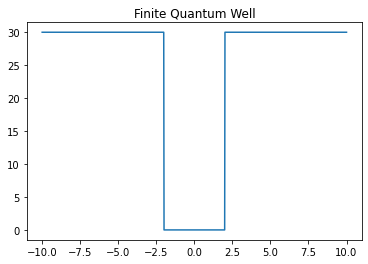

In [2]:
def Schroedinger(phi,V,E):
    return (V-E)*phi

x= np.linspace(-10,10,1000)

# Just wanted to plot the well to get an idea of the physical set-up
def well(L,mulV):
    V = np.ones(len(x))*mulV

    for i in range (len(x)):
        if (x[i]>-L and x[i]<L):
            V[i] = 0
    return V

# Testing the functions by plotting
V = well(2,30)
plt.plot(x,V)
plt.title("Finite Quantum Well")
plt.show()

In [3]:
#2nd Order Central Difference solver ** from 4 *** 
# note i call phi, time within the functions

def ODE_SolveF(condition, time, func, V, E): # function to solve the ODE
    N = len(time)
    h = (time[-1]-time[0])/(N-1) # calc h

    xpts1 = np.zeros(N)
    xpts1[0] = condition # initial conditions
    xpts1[1] = condition

    for i in range(2, N): # calc x
        xpts1[i] = 2*xpts1[i-1]-xpts1[i-2]+h**2*func(xpts1[i-1],V,E)
        
    return xpts1


def ODE_SolveB(condition, time, func, V, E):
    N = len(time)
    h = (time[-1]-time[0])/(N-1) # calc h

    xpts1 = np.zeros(N)
    xpts1[-1] = condition # initial conditions
    xpts1[-2] = condition

    for i in range(N-2,0,-1): # calc x
        xpts1[i-1] = 2*xpts1[i]-xpts1[i+1]+h**2*func(xpts1[i],V,E)
        
    return xpts1
    


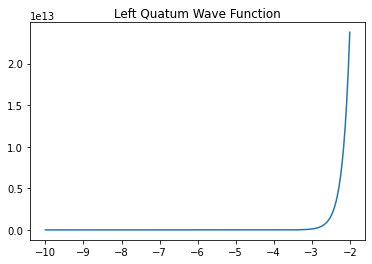

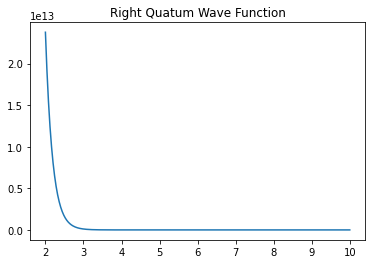

In [4]:
# Now use the functions to solve each side of the Energy well

# declare the x points for each range
xleft = np.linspace(-10,-2,400)
xmid = np.linspace(-2,2,200)
xright = np.linspace(2,10,400)

#call the functions for the left and right sides of the well
leftRange = ODE_SolveF(0.00001, xleft, Schroedinger, 30, 1)
rightRange = ODE_SolveB(0.00001, xright, Schroedinger, 30, 1)

#plot the left and right sides of the well
plt.plot(xleft, leftRange)
plt.title("Left Quatum Wave Function")
plt.show()

plt.plot(xright, rightRange)
plt.title("Right Quatum Wave Function")
plt.show()



The Energy in the first shell is =   0.5166999999999594


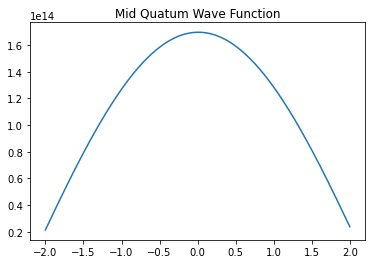

In [5]:
# Now need to deal with the middle

# new function to solve the mid
def ODE_SolveMid(condition1,condition2, time, func, V, E): # function to solve the ODE
    N = len(time)
    h = (time[-1]-time[0])/(N-1) # calc h

    xpts1 = np.zeros(N)
    xpts1[0] = condition1 # initial conditions
    xpts1[1] = condition2

    for i in range(2, N): # calc x
        xpts1[i] = 2*xpts1[i-1]-xpts1[i-2]+h**2*func(xpts1[i-1],V,E)
        
    return xpts1

# function to calc E
def findE(condition1, condition2, end, EGuess, time, V):
    
    # calc mid points
    midRange = ODE_SolveMid(condition1,condition2, time, Schroedinger, V, EGuess)
    
    while((((midRange[-1]-end)/end)>0.001)): # conditional loop
        EGuess+=0.0001 #increment E
        midRange = ODE_SolveMid(condition1, condition2, time, Schroedinger, V, EGuess) #update the mid points
    
    return EGuess


# Find the E value
E = findE(leftRange[-2], leftRange[-1], rightRange[0],0.0001,xmid, 0)

# use E to find the mid points
midRange = ODE_SolveMid(leftRange[-2],leftRange[-1], xmid, Schroedinger, 0, E)

print("The Energy in the first shell is =  ", E) #print the Energy

#print(leftSection[-2],leftSection[-1]) # test print

#plot the mid range values
plt.plot(xmid, midRange)
plt.title("Mid Quatum Wave Function")
plt.show()



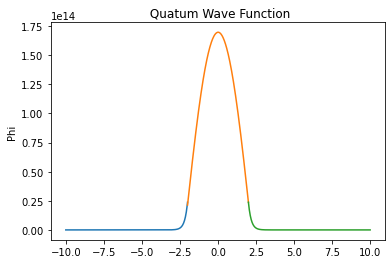

In [6]:
# ALL Together Now
# All together Now !!

plt.plot(xleft, leftRange,label = "Left Quatum Wave Function")
plt.title(" Quatum Wave Function")
plt.ylabel("Phi")

plt.plot(xmid, midRange, label = "Mid Quatum Wave Function")

plt.plot(xright, rightRange, label = "Right Quatum Wave Function")
plt.show()

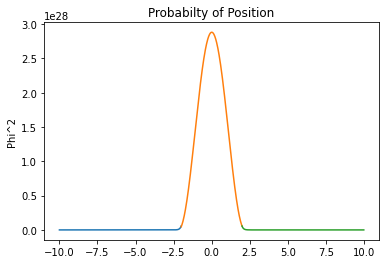

In [7]:
# plot phi^2 (Probabilty)
plt.plot(xleft, leftRange**2,label = "Left Quatum Wave Function")
plt.title("Probabilty of Position")
plt.ylabel("Phi^2")
plt.plot(xmid, midRange**2, label = "Mid Quatum Wave Function")

plt.plot(xright, rightRange**2, label = "Right Quatum Wave Function")
plt.show()



This is for the first energy level of the quantum well, $n=1$.  Solve the solution 4 more times for $n = 2, 3, 4, 5$.  For your initial guesses, remember than quantum well energies of excited states are $E(n) = n^2 E(1)$.  (Note that for $n=2, 4$, the middle section will end up negative.  To remedy this, make the points in the right hand barrier negative.)  Print the energies of these levels as well as the graphs for $\phi(x)$ and $\phi^2(x)$.

Finally, run your code with an initial guess of $E = 40$. Plot the result.  **Question:  Is this result consistent with the physics of the situation?**

![Finite_Potential_Well_Symmetric.png](attachment:Finite_Potential_Well_Symmetric.png)

The Energy in the 2 shell is =   2.0667999999998377


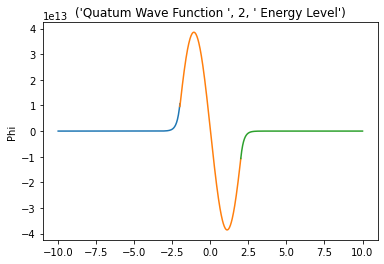

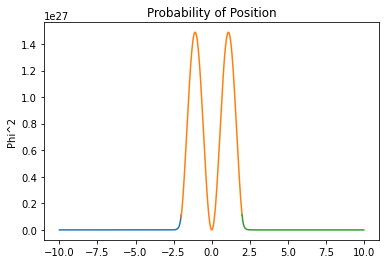

In [8]:
# just re-declaring the x points (probably not needed)
xleft = np.linspace(-10,-2,400)
xmid = np.linspace(-2,2,200)
xright = np.linspace(2,10,400)

# function for the energy depending on the shell
def Energy(n):
    return E*n**2

# function to plot the energy levels
def plot(n):
    # calling the sections
    leftRange = ODE_SolveF(0.00001, xleft, Schroedinger, 30, Energy(n))
    rightRange = ODE_SolveB(0.00001, xright, Schroedinger, 30, Energy(n))
    midRange = ODE_SolveMid(leftRange[-2],leftRange[-1], xmid, Schroedinger, 0, Energy(n))
    
    if (n%2==0): # condition to flipp the right side
        rightRange = rightRange*-1
        
    print("The Energy in the",n, "shell is =  ", Energy(n)) # print the energy val
    
    title = "Quatum Wave Function ",n, " Energy Level"
    title2 = "Probability of Position"

    # plot the Energy level
    plt.plot(xleft, leftRange,label = "Left Quatum Wave Function")
    plt.title(title)
    plt.ylabel("Phi")
    plt.plot(xmid, midRange, label = "Mid Quatum Wave Function")
    plt.plot(xright, rightRange, label = "Right Quatum Wave Function")
    plt.show()
    
    plt.plot(xleft, leftRange**2,label = "Left Quatum Wave Function")
    plt.title(title2)
    plt.ylabel("Phi^2")
    plt.plot(xmid, midRange**2, label = "Mid Quatum Wave Function")
    plt.plot(xright, rightRange**2, label = "Right Quatum Wave Function")
    plt.show()
    
    return

plot(2) # call function for 2nd shell
    



The Energy in the 3 shell is =   4.650299999999635


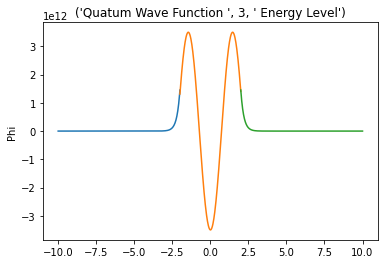

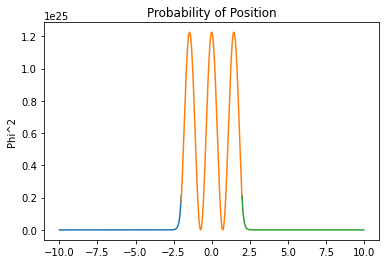

In [9]:
plot(3) # call function for 3rd shell

The Energy in the 4 shell is =   8.26719999999935


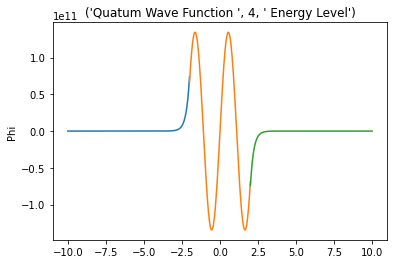

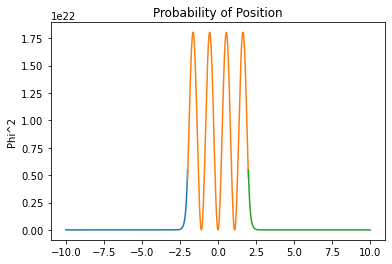

In [10]:
plot(4) # call function for 4th shell

The Energy in the 5 shell is =   12.917499999998986


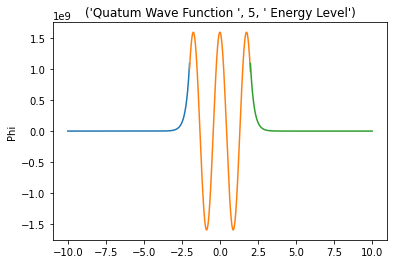

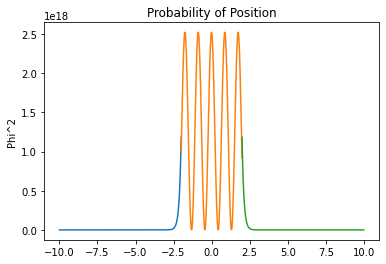

In [11]:
plot(5) # call function for 5th shell

Finally, run your code with an initial guess of  𝐸=40 . Plot the result. Question: Is this result consistent with the physics of the situation?

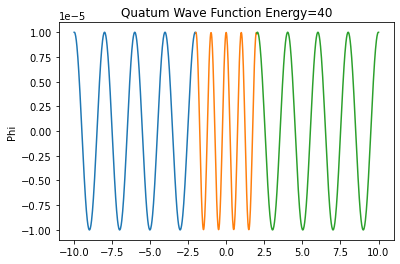

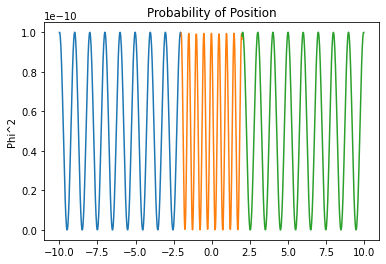

In [12]:
# Initial Guess of E = 40
# using n = 40, plotting the energy

leftRange = ODE_SolveF(0.00001, xleft, Schroedinger, 30, 40)
rightRange = ODE_SolveB(0.00001, xright, Schroedinger, 30, 40)
midRange = ODE_SolveMid(leftRange[-2],leftRange[-1], xmid, Schroedinger, 0, 40)

        
    
title = "Quatum Wave Function Energy=40"
title2 = "Probability of Position"

    
plt.plot(xleft, leftRange,label = "Left Quatum Wave Function")
plt.title(title)
plt.ylabel("Phi")
plt.plot(xmid, midRange, label = "Mid Quatum Wave Function")
plt.plot(xright, rightRange, label = "Right Quatum Wave Function")
plt.show()
    
plt.plot(xleft, leftRange**2,label = "Left Quatum Wave Function")
plt.title(title2)
plt.ylabel("Phi^2")
plt.plot(xmid, midRange**2, label = "Mid Quatum Wave Function")
plt.plot(xright, rightRange**2, label = "Right Quatum Wave Function")
plt.show()


This System follows the physics of a finite quantum well since for models where E less than V the Energy outside of the well trends toward zero. However when E greater than V some of the energy can escape the finite well so the left-over energy oscillates outside the well.

## Acknowledgements

Please comment on any help that you received from your group members or others concerning this Lab assignment.

In [13]:
# All code was written by Nathan Pacey. Topics were discussed with Stuart Gaherty, Conner Legg and Ekin Yelken.